<a href="https://colab.research.google.com/github/coda-nsit/kaggle/blob/master/ImageClassification_Food_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
1. Take a CNN that has been pre-trained (typically ImageNet)
2. Remove the last fully-connected layer and replaces it with our custom fully-connected layer.
3. treating the original CNN as a feature extractor for the new dataset. Once replaced the last fully-connected layer we train the classifier for the new dataset.

# References:
1. https://medium.com/abraia/first-steps-with-transfer-learning-for-custom-image-classification-with-keras-b941601fcad5

2. usage of *flow_from_dataframe* and *flow_from_directory*: https://keras.io/preprocessing/image/

3. transfer learning using Tensorflow: https://becominghuman.ai/transfer-learning-retraining-inception-v3-for-custom-image-classification-2820f653c557

4. rescale=1./255 vs preprocess-input: https://stackoverflow.com/questions/54702212/keras-rescale-1-255-vs-preprocessing-function-preprocess-input-which-one-to

# Load the libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from PIL import Image

from keras.models import load_model
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Flatten
from keras import backend as K
from keras.preprocessing import image

# Load the data

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!ls
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle

kaggle.json  sample_data


In [0]:
%%capture
!kaggle competitions download -c ifood-2019-fgvc6

In [0]:
!unzip -q train_set.zip
!unzip -q train_labels.csv.zip

In [0]:
!unzip -q val_set.zip
!unzip -q test_set.zip

# Preprocessing of the input data

## Map the idx and the class names


In [0]:
label_names = []
label_idxs = []
idx_to_name = {}
with open("class_list.txt") as label_file:
  for line in label_file:
    idx, label = line.split(" ")
    label_names.append(label)
    label_idxs.append(int(idx))
    idx_to_name[int(idx)] = label

In [0]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
                preprocessing_function=preprocess_input,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
# only rescaling
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
sample = 6000
df_train = pd.read_csv('/content/train_labels.csv')
df_val   = pd.read_csv('/content/val_labels.csv')

# convert class to string
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)

display(df_train.head())

df_train = df_train.sample(sample) 
df_val  = df_val.sample(sample)

df_train.shape, df_val.shape

,img_name,label
0,train_101733.jpg,211
1,train_101734.jpg,211
2,train_101735.jpg,211
3,train_101736.jpg,211
4,train_101737.jpg,211


((6000, 2), (6000, 2))

In [10]:
batch_size  = 36

train_generator = train_datagen.flow_from_dataframe(
                df_train,
                x_col='img_name',
                y_col='label',    
                class_mode='categorical',
                directory='/content/train_set/',  # this is the target directory
                shuffle = True,
                target_size=(256, 256),  # all images will be resized to 150x150
                batch_size=batch_size)   # since we use binary_crossentropy loss, we need binary labels


validation_generator = validation_datagen.flow_from_dataframe(
                df_val,
                x_col='img_name',
                y_col='label',    
                class_mode='categorical',
                directory='/content/val_set/',  # this is the target directory
                shuffle = False,
                target_size=(256, 256),  # all images will be resized to 150x150
                batch_size=batch_size)  # since we use binary_crossentropy loss, we need binary labels


Found 6000 validated image filenames belonging to 251 classes.
Found 6000 validated image filenames belonging to 251 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

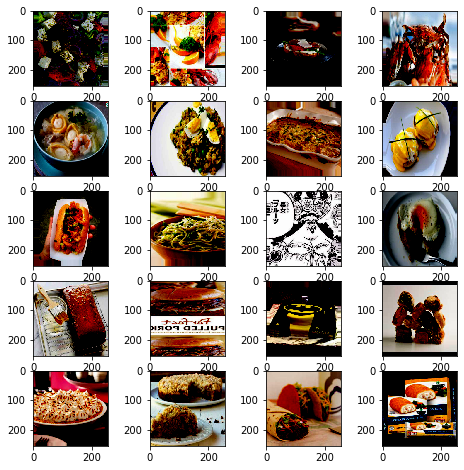

In [11]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns * rows + 1):
    img = train_generator.next()[0][0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Create the model

### Initialize the default model, removing the last layer

In [12]:
# don't use the last layer, as we will customize it
base_model = InceptionV3(weights='imagenet', include_top=False)














87916544/87910968 [==============================] - 2s 0us/step


### Add custom classification layer

In [14]:
CLASSES = 251
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
shape = K.int_shape(predictions)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### Frezze all the layer weights except the last one
An additional step can be performed after this initial training un-freezing some lower convolutional layers and retraining the classifier with a lower learning rate. This fine-tuning step increases the network accuracy but must be carefully carried out to avoid overfitting.

In [0]:
for layer in base_model.layers:
    layer.trainable = False

### Compile the model

In [17]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Data Augmentation-- fit the model

In [18]:
EPOCHS = 8
BATCH_SIZE = 36
STEPS_PER_EPOCH = len(train_generator)
VALIDATION_STEPS = len(validation_generator)
MODEL_FILE = 'inception-finetuned.model'

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS)
  
model.save(MODEL_FILE)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/8
167/167 [==============================] - 2445s 15s/step - loss: 5.6427 - acc: 0.0201 - val_loss: 5.4411 - val_acc: 0.0545
Epoch 2/8
167/167 [==============================] - 2423s 15s/step - loss: 4.6588 - acc: 0.1017 - val_loss: 5.2284 - val_acc: 0.0865
Epoch 3/8
167/167 [==============================] - 2411s 14s/step - loss: 4.0679 - acc: 0.1794 - val_loss: 5.3523 - val_acc: 0.0985
Epoch 4/8
167/167 [==============================] - 2398s 14s/step - loss: 3.6705 - acc: 0.2290 - val_loss: 5.4195 - val_acc: 0.1067
Epoch 5/8
167/167 [==============================] - 2403s 14s/step - loss: 3.3911 - acc: 0.2751 - val_loss: 5.6500 - val_acc: 0.1142
Epoch 6/8
167/167 [==============================] - 2403s 14s/step - loss: 3.1682 - acc: 0.3140 - val_loss: 5.7684 - val_acc: 0.1250
Epoch 7/8
167/167 [==============================] - 2418s 14s/step - loss: 2.9864 - acc: 0.3389 - v

### Plot the training results

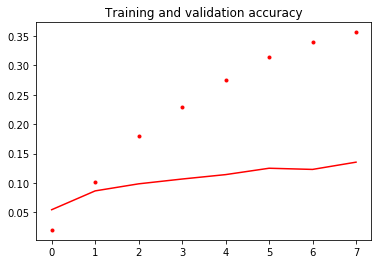

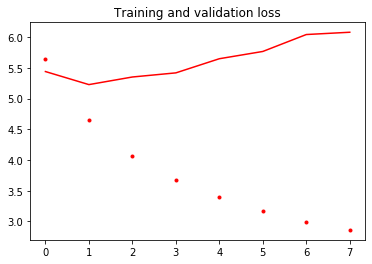

In [19]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

# Prediction of the custom model

In [0]:
def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


# def plot_preds(img, preds):
#     """Displays image and the top-n predicted probabilities in a bar graph
#     Args:
#         preds: list of predicted labels and their probabilities
#     """
#     labels = ("cat", "dog")
#     gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
#     plt.figure(figsize=(8,8))
#     plt.subplot(gs[0])
#     plt.imshow(np.asarray(img))
#     plt.subplot(gs[1])
#     plt.barh([0, 1], preds, alpha=0.5)
#     plt.yticks([0, 1], labels)
#     plt.xlabel('Probability')
#     plt.xlim(0, 1)
#     plt.tight_layout()

In [0]:
model = load_model(MODEL_FILE)

In [41]:
img = image.load_img('/content/val_set/val_004819.jpg', target_size=(256, 256))
preds = predict(model, img)
print("predictions", len(preds), np.argmax(preds), idx_to_name[np.argmax(preds)])
# plot_preds(np.asarray(img), preds)

predictions 251 77 coq_au_vin



In [26]:
df_val.head()

,img_name,label
8926,val_007215.jpg,38
7590,val_005857.jpg,51
5080,val_003318.jpg,209
9919,val_008216.jpg,35
2144,val_000334.jpg,51


In [0]:
!ls /content/val_set/